Imports

[CN] Step 2000/20000, t=4.0000, ∫f=1.020406, min=0.000e+00, max=1.526e+00
[CN] Step 4000/20000, t=8.0000, ∫f=1.020187, min=0.000e+00, max=1.142e+00
[CN] Step 6000/20000, t=12.0000, ∫f=1.039973, min=0.000e+00, max=8.844e-01
[CN] Step 8000/20000, t=16.0000, ∫f=1.044894, min=0.000e+00, max=6.547e-01
[CN] Step 10000/20000, t=20.0000, ∫f=1.052692, min=0.000e+00, max=4.958e-01
[CN] Step 12000/20000, t=24.0000, ∫f=1.066053, min=0.000e+00, max=3.986e-01
[CN] Step 14000/20000, t=28.0000, ∫f=1.069054, min=0.000e+00, max=3.582e-01
[CN] Step 16000/20000, t=32.0000, ∫f=1.077200, min=0.000e+00, max=3.142e-01
[CN] Step 18000/20000, t=36.0000, ∫f=1.083448, min=0.000e+00, max=2.658e-01
[CN] Step 20000/20000, t=40.0000, ∫f=1.086706, min=0.000e+00, max=2.317e-01


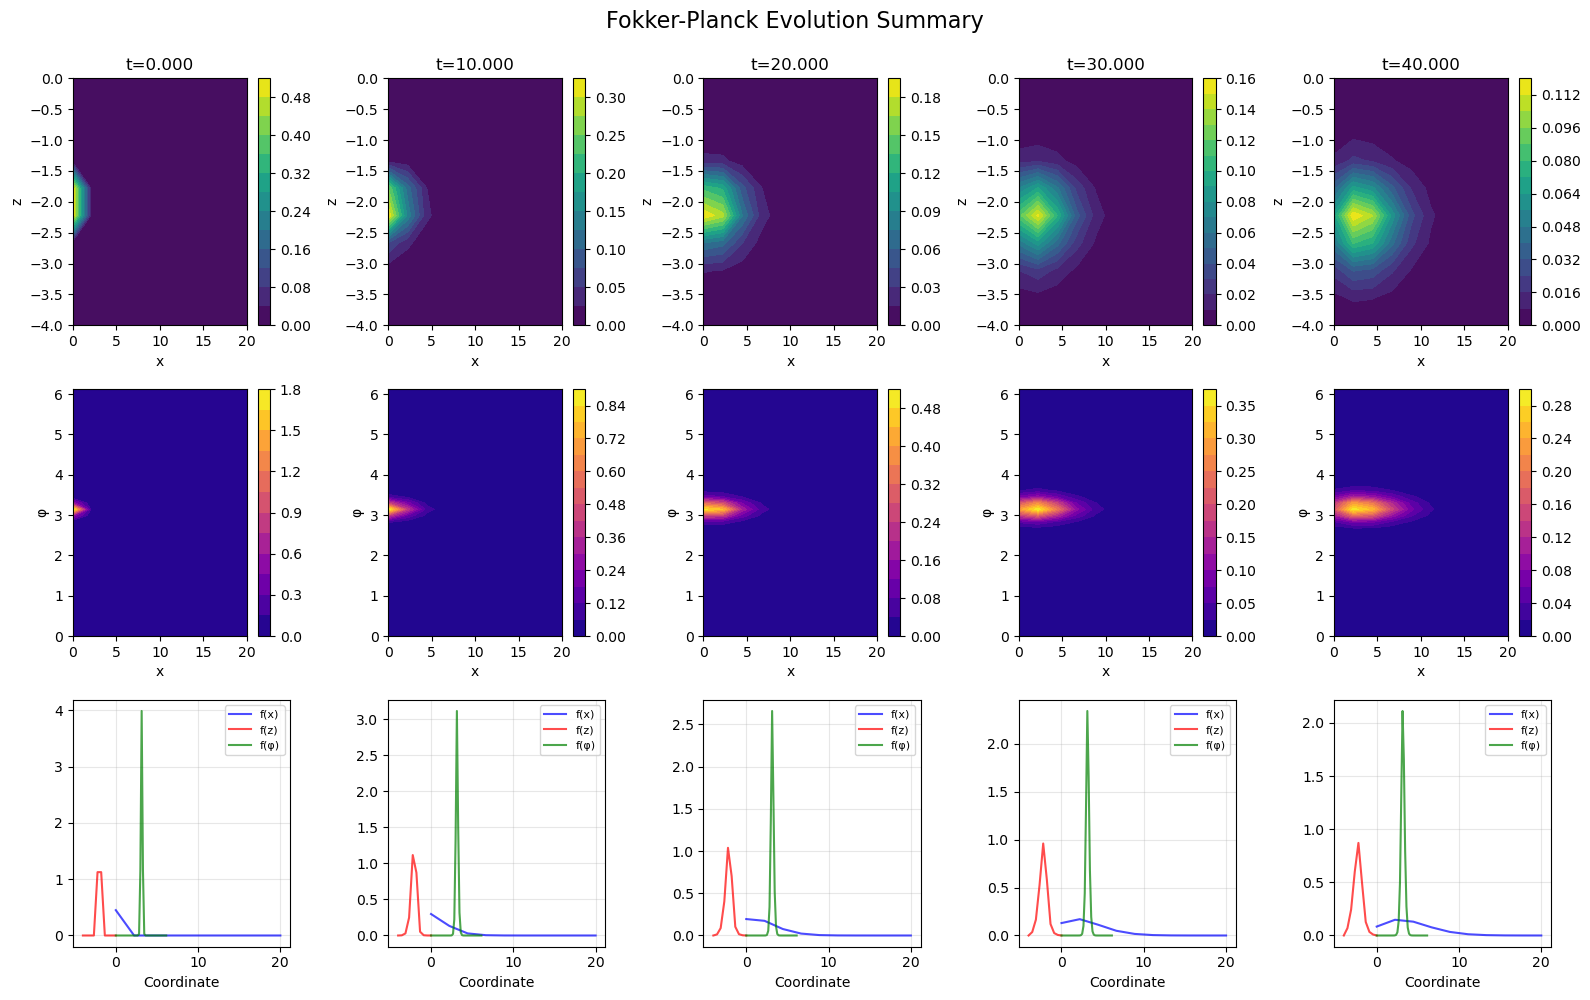

yay


In [73]:
import numpy as np
import matplotlib.pyplot as plt

# ----------------- parameters -----------------

sigma = 0.001
beta = 100        # also used in the domain z ∈ [-beta, 0]
lamda = 0.6
alpha = 0.1
v0 = 0.01
vg = 0.0
psi = np.inf
D0 = 0.0001    # rotational diffusion coefficient

# ----------------- grid -----------------

nx, nz, nphi = 10, 10, 40
xmin, xmax   = 0.0, 20   # x-domain
# z-domain is [-beta, 0] with beta defined above

x   = np.linspace(xmin, xmax, nx)
z   = np.linspace(-4, 0.0, nz)
phi = np.linspace(0.0, 2*np.pi, nphi, endpoint=False)

dx   = x[1]   - x[0]
dz   = z[1]   - z[0]
dphi = phi[1] - phi[0]

X, Z, PHI = np.meshgrid(x, z, phi, indexing="ij")

# ----------------- drift and noise (vectorised) -----------------

def mu_x_vec(X, Z, PHI, t):
    """Vectorized x-direction drift"""
    return alpha*np.exp(Z)*np.cos(X - t) + v0*np.sin(PHI) + sigma*(beta + Z)

def mu_z_vec(X, Z, PHI, t):
    """Vectorized z-direction drift"""
    return alpha*np.exp(Z)*np.sin(X - t) + v0*np.cos(PHI) - vg

def mu_phi_vec(X, Z, PHI, t):
    """Vectorized phi-direction drift"""
    return (lamda*alpha*np.exp(Z)*np.cos(X - t + 2*PHI)
            - 1/(2*psi)*np.sin(PHI)
            + sigma/2*(1 + lamda*np.cos(2*PHI)))

def var_vec(X, Z, PHI, t):
    """Vectorized noise intensity (if needed elsewhere)"""
    return D0 * np.ones_like(X)

# optional extremised drifts (for CFL of explicit scheme)
def mu_x_max(X, Z, PHI, t):
    return alpha*np.exp(Z) + v0 + sigma*(beta + Z)

def mu_z_max(X, Z, PHI, t):
    return alpha*np.exp(Z) + v0 - vg

def mu_phi_max(X, Z, PHI, t):
    return lamda*alpha*np.exp(Z) - 1/(2*psi) + sigma/2*(1 + lamda)

# ----------------- CN machinery in φ -----------------

def build_cn_matrix_phi(Nphi, dt, D0, dphi):
    """
    Build Crank–Nicolson matrix in φ for diffusion term D0 ∂_φ^2 f.
    Periodic in φ.
    """
    r = D0 * dt / dphi**2

    main = (1.0 + r) * np.ones(Nphi)
    off  = (-0.5 * r) * np.ones(Nphi - 1)

    A = np.diag(main)
    A += np.diag(off,  1)
    A += np.diag(off, -1)

    # periodic coupling
    A[0,  -1] = -0.5 * r
    A[-1,  0] = -0.5 * r

    return A

def laplacian_phi(f, dphi):
    """Central 2nd derivative in φ with periodic BC (axis=2)."""
    return (np.roll(f, -1, axis=2)
            - 2.0 * f
            + np.roll(f,  1, axis=2)) / dphi**2

# ----------------- drift operator (upwind) -----------------

def drift_operator_upwind(f, X, Z, PHI, t, dx, dz, dphi,
                          bc_x='open', bc_z='absorbing', bc_phi='periodic'):
    """
    Drift term: -∂_x(μ_x f) - ∂_z(μ_z f) - ∂_φ(μ_φ f),
    first-order upwind in all directions.
    """
    Nx, Nz, Nphi = f.shape

    # Drift fields
    MU_X   = mu_x_vec(X, Z, PHI, t)
    MU_Z   = mu_z_vec(X, Z, PHI, t)
    MU_PHI = mu_phi_vec(X, Z, PHI, t)

    # ---- X direction (periodic) ----
    MUx_p = np.maximum(MU_X, 0.0)
    MUx_m = np.minimum(MU_X, 0.0)

    fx_plus  = f - np.roll(f,  1, axis=0)   # f_i - f_{i-1}
    fx_minus = np.roll(f, -1, axis=0) - f   # f_{i+1} - f_i

    Lx = -(MUx_p * fx_plus + MUx_m * fx_minus) / dx

    # ---- Z direction (absorbing at both ends) ----
    MUz_p = np.maximum(MU_Z, 0.0)
    MUz_m = np.minimum(MU_Z, 0.0)

    Lz = np.zeros_like(f)
    # interior j = 1..Nz-2
    fz_plus  = f[:, 1:-1, :] - f[:, 0:-2, :]
    fz_minus = f[:, 2:   , :] - f[:, 1:-1, :]

    Lz[:, 1:-1, :] = -(MUz_p[:, 1:-1, :] * fz_plus
                       + MUz_m[:, 1:-1, :] * fz_minus) / dz

    # j=0 and j=Nz-1 left as 0 → flux goes out, absorbed by BC on f

    # ---- φ direction (periodic) ----
    MUphi_p = np.maximum(MU_PHI, 0.0)
    MUphi_m = np.minimum(MU_PHI, 0.0)

    fphi_plus  = f - np.roll(f,  1, axis=2)     # f_k - f_{k-1}
    fphi_minus = np.roll(f, -1, axis=2) - f     # f_{k+1} - f_k

    Lphi = -(MUphi_p * fphi_plus + MUphi_m * fphi_minus) / dphi

    return Lx + Lz + Lphi

# ----------------- plotting helpers -----------------

def plot_state(f, x_grid, z_grid, phi_grid, t, axes=None, fig=None):
    """
    Plot current state:
      - f(x,z) (integrated over φ)
      - f(x,φ) (integrated over z)
      - f(z,φ) (integrated over x)
      - 1D marginals f(x), f(z), f(φ)
    Reuses fig, axes if given; otherwise creates them.
    Returns (fig, axes).
    """
    if fig is None or axes is None:
        fig, axes = plt.subplots(2, 2, figsize=(12, 8))
        plt.ion()

    for ax in axes.flat:
        ax.clear()
    
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    # 1. Marginal in (x, z) - integrate over phi
    f_xz = np.sum(f, axis=2) * dphi
    im1 = axes[0, 0].contourf(x_grid, z_grid, f_xz.T, levels=20, cmap='viridis')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('z')
    axes[0, 0].set_title(f'Marginal f(x,z) at t={t:.3f}')
    fig.colorbar(im1, ax=axes[0, 0])
    
    # 2. Marginal in (x, phi) - integrate over z
    f_xphi = np.sum(f, axis=1) * dz
    im2 = axes[0, 1].contourf(x_grid, phi_grid, f_xphi.T, levels=20, cmap='plasma')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('φ')
    axes[0, 1].set_title(f'Marginal f(x,φ)')
    fig.colorbar(im2, ax=axes[0, 1])
    
    # 3. Marginal in (z, phi) - integrate over x
    f_zphi = np.sum(f, axis=0) * dx
    im3 = axes[1, 0].contourf(z_grid, phi_grid, f_zphi.T, levels=20, cmap='coolwarm')
    axes[1, 0].set_xlabel('z')
    axes[1, 0].set_ylabel('φ')
    axes[1, 0].set_title(f'Marginal f(z,φ)')
    fig.colorbar(im3, ax=axes[1, 0])
    
    # 4. 1D marginals
    f_x   = np.sum(f, axis=(1, 2)) * dz * dphi
    f_z   = np.sum(f, axis=(0, 2)) * dx * dphi
    f_phi = np.sum(f, axis=(0, 1)) * dx * dz
    
    axes[1, 1].plot(x_grid,  f_x,   'b-', label='f(x)', linewidth=2)
    axes[1, 1].plot(z_grid,  f_z,   'r-', label='f(z)', linewidth=2)
    axes[1, 1].plot(phi_grid, f_phi, 'g-', label='f(φ)', linewidth=2)
    axes[1, 1].set_xlabel('Coordinate')
    axes[1, 1].set_ylabel('Probability density')
    axes[1, 1].set_title('1D Marginals')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    fig.tight_layout()
    plt.pause(0.01)
    return fig, axes

def plot_summary(solution, t_array, x_grid, z_grid, phi_grid, save_path=None):
    """Create comprehensive summary plots after simulation"""
    dx = x_grid[1] - x_grid[0]
    dz = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    
    fig = plt.figure(figsize=(16, 10))
    
    # Select key time points
    time_indices = [0, len(t_array)//4, len(t_array)//2, 3*len(t_array)//4, -1]
    
    for idx, ti in enumerate(time_indices):
        f = solution[ti]
        t = t_array[ti]
        
        # Plot marginal in (x, z)
        ax = plt.subplot(3, 5, idx+1)
        f_xz = np.sum(f, axis=2) * dphi
        im = ax.contourf(x_grid, z_grid, f_xz.T, levels=15, cmap='viridis')
        ax.set_xlabel('x')
        ax.set_ylabel('z')
        ax.set_title(f't={t:.3f}')
        plt.colorbar(im, ax=ax)
        
        # Plot marginal in (x, phi)
        ax = plt.subplot(3, 5, idx+6)
        f_xphi = np.sum(f, axis=1) * dz
        im = ax.contourf(x_grid, phi_grid, f_xphi.T, levels=15, cmap='plasma')
        ax.set_xlabel('x')
        ax.set_ylabel('φ')
        plt.colorbar(im, ax=ax)
        
        # Plot 1D marginals
        ax = plt.subplot(3, 5, idx+11)
        f_x   = np.sum(f, axis=(1, 2)) * dz * dphi
        f_z   = np.sum(f, axis=(0, 2)) * dx * dphi
        f_phi = np.sum(f, axis=(0, 1)) * dx * dz
        ax.plot(x_grid,  f_x,   'b-', label='f(x)', alpha=0.7)
        ax.plot(z_grid,  f_z,   'r-', label='f(z)', alpha=0.7)
        ax.plot(phi_grid, f_phi, 'g-', label='f(φ)', alpha=0.7)
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.set_xlabel('Coordinate')
    
    plt.suptitle('Fokker-Planck Evolution Summary', fontsize=16, y=0.995)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"Summary plot saved to: {save_path}")
    
    plt.show()
    
    return fig

# ----------------- one CN step (IMEX) -----------------

def fokker_planck_step_cn(
    f, X, Z, PHI,
    t, dt, dx, dz, dphi,
    A_phi_inv, D0,
    *,  # everything after this is keyword-only
    bc_x='open', bc_z='absorbing', bc_phi='periodic'
):
    """
    One time step:
      - drift explicit (upwind)
      - φ-diffusion Crank–Nicolson (implicit)
      - absorbing BC in z at both ends
    """
    Nx, Nz, Nphi = f.shape

    # 1. Enforce absorbing BC in z BEFORE computing drift
    f[:,  0, :] = 0.0       # z = -beta
    f[:, -1, :] = 0.0       # z = 0

    # 2. Drift part at time n
    L_drift_f = drift_operator_upwind(
        f, X, Z, PHI, t, dx, dz, dphi,
        bc_x=bc_x, bc_z=bc_z, bc_phi=bc_phi
    )

    # 3. φ-Laplacian at time n
    lap_f = laplacian_phi(f, dphi)

    # 4. Build RHS for CN solve in φ
    RHS = f + dt * L_drift_f + 0.5 * D0 * dt * lap_f

    # 5. Solve (I - 0.5*D0*dt*∂_φ^2) f^{n+1} = RHS
    f_new = np.empty_like(f)
    for i in range(Nx):
        for j in range(Nz):
            f_new[i, j, :] = A_phi_inv @ RHS[i, j, :]

    # 6. Enforce absorbing BC after step
    f_new[:,  0, :] = 0.0
    f_new[:, -1, :] = 0.0

    # 7. Positivity fix (optional)
    f_new = np.maximum(f_new, 0.0)

    return f_new

# ----------------- full CN solver -----------------

def solve_fokker_planck_cn(
    f0, t_array, x_grid, z_grid, phi_grid, D0,
    *,  # BCs and flags keyword-only
    bc_x='open', bc_z='absorbing', bc_phi='periodic',
    verbose=True, live_plot=False, plot_interval=50
):
    """
    Time integration using Crank–Nicolson in φ + upwind drift.
    """
    Nt = len(t_array)
    Nx, Nz, Nphi = f0.shape

    dx   = x_grid[1] - x_grid[0]
    dz   = z_grid[1] - z_grid[0]
    dphi = phi_grid[1] - phi_grid[0]
    dt   = t_array[1] - t_array[0]    # assume uniform time grid

    # Meshgrids
    X, Z, PHI = np.meshgrid(x_grid, z_grid, phi_grid, indexing='ij')

    # Precompute CN matrix and its inverse in φ
    A_phi     = build_cn_matrix_phi(Nphi, dt, D0, dphi)
    A_phi_inv = np.linalg.inv(A_phi)

    solution = np.zeros((Nt, Nx, Nz, Nphi))
    solution[0] = f0.copy()

    fig = axes = None
    if live_plot:
        fig, axes = plot_state(solution[0], x_grid, z_grid, phi_grid,
                               t_array[0], axes=None, fig=None)

    for n in range(Nt - 1):
        t = t_array[n]
        f = solution[n]

        f_new = fokker_planck_step_cn(
            f, X, Z, PHI,
            t, dt, dx, dz, dphi,
            A_phi_inv, D0,
            bc_x=bc_x, bc_z=bc_z, bc_phi=bc_phi
        )
        solution[n+1] = f_new

        if verbose and (n+1) % max(1, Nt//10) == 0:
            total_prob = np.sum(f_new) * dx * dz * dphi
            print(f"[CN] Step {n+1}/{Nt-1}, t={t_array[n+1]:.4f}, "
                  f"∫f={total_prob:.6f}, min={f_new.min():.3e}, max={f_new.max():.3e}")

        if live_plot and (n+1) % plot_interval == 0:
            fig, axes = plot_state(
                f_new, x_grid, z_grid, phi_grid,
                t_array[n+1], axes=axes, fig=fig
            )

    if live_plot:
        plt.ioff()
        plt.show()

    return solution

# ----------------- time grid and initial condition -----------------

t_final = 40
dt      = 0.002
Nt      = int(t_final / dt) + 1
t_array = np.linspace(0, t_final, Nt)

x0   = 0.0
z0   = -2         # middle of [-beta, 0]
phi0 = np.pi                  # centre angle (choose e.g. 0 or np.pi/2)

# choose widths ~ a few grid steps (so it's resolved but localized)
sigma_init = 0.1

#should sigma be the same for all variables??
# sigma_x   = 2.0 * dx
# sigma_z   = 2.0 * dz
# sigma_phi = 2.0 * dphi

sigma_x   = sigma_init
sigma_z   = sigma_init
sigma_phi = sigma_init

# Gaussian in x, z, and φ
f0 = np.exp(
    -((X - x0)**2      / (2 * sigma_x**2)
      + (Z - z0)**2    / (2 * sigma_z**2)
      + (PHI - phi0)**2 / (2 * sigma_phi**2))
)

# normalise to total probability 1
volume_element = dx * dz * dphi
norm = np.sum(f0) * volume_element
f0 /= norm

# absorbing BC at z-boundaries
f0[:,  0, :] = 0.0   # z = -beta
f0[:, -1, :] = 0.0   # z = 0

# ----------------- run CN solver -----------------

solution_cn = solve_fokker_planck_cn(
    f0, t_array, x, z, phi, D0,
    bc_x='open', bc_z='absorbing', bc_phi='periodic',
    verbose=True, live_plot=False, plot_interval=20
)

# summary plots after simulation
plot_summary(solution_cn, t_array, x, z, phi)
print('yay')